<a href="https://colab.research.google.com/github/gil612/PyTorch/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment
What is model deployment?
Machine Learning model deployment is the act of making your machine learning model(s) available to someone or something else.


## 0. Get Setup

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [3]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file():
  print()
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/gil612/PyTorch/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 37.89 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [6]:
import os
import zipfile

from pathlib import Path

import requests



def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """ """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path /destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
      print(f"[INFO] {image_path} directory already exists... skipping download")
    else:
      print(f"[INFO] {image_path} does not exist, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)

    # Download the target data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)

    # Unzip target_file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    # Remove .zip file if needed
    if remove_source:
      os.remove(data_path / target_file)

    return image_path

In [7]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi does not exist, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Foodvision Mini Model deployment experiment outline

### 3 questions
1. What is my most ideal machine learning model deployment scenario?
2. 'where is my model going to function?

**FoodVision Mini ideal use case:** A model that perform wellm and fast.

1. Perfoems well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS + or 30ms latency)
  * Latency = time for prediction to take place

To try achive these goals, we're going to buils two midel wxperiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a ceretain problem.

EffNetB2 pretraind model in PyTorch:
--Link--


In [10]:
import torchvision




effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 82.0MB/s]


In [11]:
from torchinfo import summary
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [12]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=1000, bias=True))

### 3.1 Creaating a function to make EffNetB2 feature Extractor

In [13]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes) )

  return model, transforms

In [14]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3, seed = 42)

In [15]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 288, 288),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 10,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288] [1, 3]     --         Partial
├─Sequential (features)                                      [1, 3, 288, 288] [1, 1408, 9, 9] --         False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288] [1, 32, 144, 144] --         False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288] [1, 32, 144, 144] (864)      False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144] [1, 32, 144, 144] (64)       False
│    │    └─SiLU (2)                                         [1, 32, 144, 144] [1, 32, 144, 144] --         --
│    └─Sequential (1)                                        [1, 32, 144, 144] [1, 16, 144, 144] --         False
│    │    └─MBConv (0)                                       [1, 32, 144, 144] [1, 16, 144, 144] (1,448)    F

### 3.2 Creating DataLoaders for EffNetB2

In [17]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                 test_dir= test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32
                                                                                                 )


In [18]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [19]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                 train_dataloader=train_dataloader_effnetb2,
                                 test_dataloader=test_dataloader_effnetb2,
                                 epochs=10,
                                 optimizer = optimizer,
                                 loss_fn = loss_fn,
                                 device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0949 | train_acc: 0.3594 | test_loss: 0.9081 | test_acc: 0.7850
Epoch: 2 | train_loss: 0.8829 | train_acc: 0.7109 | test_loss: 0.8509 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.7849 | train_acc: 0.8281 | test_loss: 0.7742 | test_acc: 0.7746
Epoch: 4 | train_loss: 0.7204 | train_acc: 0.7578 | test_loss: 0.6635 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.6443 | train_acc: 0.8164 | test_loss: 0.6514 | test_acc: 0.8570
Epoch: 6 | train_loss: 0.5654 | train_acc: 0.9219 | test_loss: 0.5848 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.5171 | train_acc: 0.9336 | test_loss: 0.5634 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.5601 | train_acc: 0.7891 | test_loss: 0.5740 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5473 | train_acc: 0.8125 | test_loss: 0.5411 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.4758 | train_acc: 0.8398 | test_loss: 0.4636 | test_acc: 0.9072


### 3.4 Inspecting EffNetB2 loss curves

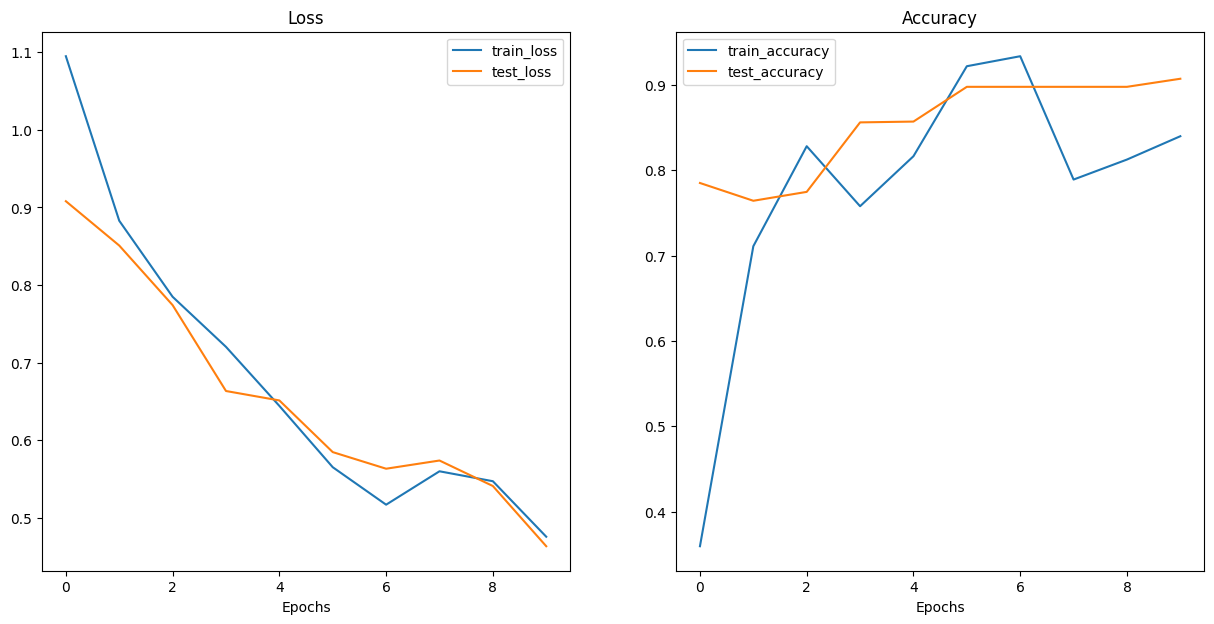

In [20]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [21]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6. Inspecting the size of our EffNetB2 feature extractor

Size of saved model is importnant . There may be limited compute resources. We wouldn't be able to run on our target device.

In [22]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("/content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size,2)}MB")

pretrained EffNetB2 feature extractor model size: 29.86MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [23]:
# count numebr of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [24]:
# Create a dictionary with EffNetB2 statistics
effnetB2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parametrs":effnetb2_total_params,
                  "modelsize (MB)" : pretrained_effnetb2_model_size}

In [25]:
effnetB2_stats

{'test_loss': 0.46357306838035583,
 'test_acc': 0.9071969696969697,
 'number_of_parametrs': 7705221,
 'modelsize (MB)': 29.8638858795166}

## 4. Creating ViT feature extractor

In [26]:
# Check out the head layer

vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [27]:
def create_vit_model(num_classes:int=3, seed:int=42):
  # pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

### WARNING : A type spelling of the function requires_grad won't raise an exception
  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=num_classes))

  return model, transforms

In [28]:
vit, vit_transforms = create_vit_model(3,42)
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 162MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [29]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [30]:
from torchinfo import summary

summary(vit,
        input_size=(1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 10,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]     768        Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)  False
├─Encoder (encoder)                                          [1, 197, 768] [1, 197, 768] 151,296    False
│    └─Dropout (dropout)                                     [1, 197, 768] [1, 197, 768] --         --
│    └─Sequential (layers)                                   [1, 197, 768] [1, 197, 768] --         False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768] [1, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768] [1, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768] [1, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_lay

### 4.1 Create DataLoader for ViT feature extractor

In [31]:
# Setup ViT DataLoader
from going_modular.going_modular import data_setup

# Create a bathc size of 32 (the paper uses 4096 but this may be too big for our sma)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extraxtor

We'reup to model experiment number twoL a ViT feature extractor

In [32]:
from going_modular.going_modular import engine

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Training function (engine.py)
set_seeds()
vit_results = engine.train(model=vit,
                                 train_dataloader=train_dataloader_vit,
                                 test_dataloader=test_dataloader_vit,
                                 epochs=10,
                                 optimizer = optimizer,
                                 loss_fn = loss_fn,
                                 device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 4.3 Plot loss curves on ViT feature extractor

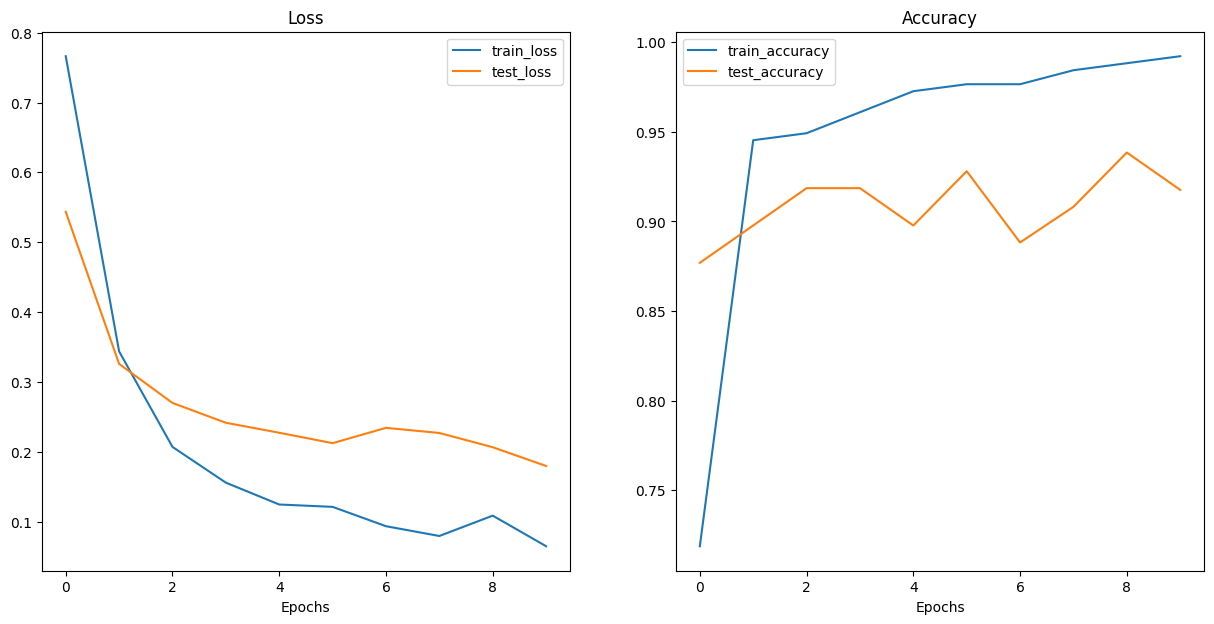

In [33]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [34]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir = "models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [35]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("/content/models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"pretrained ViT feature extractor model size: {round(pretrained_vit_model_size,2)}MB")

pretrained_effnetb2_model_size = Path("/content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size,2)}MB")

pretrained ViT feature extractor model size: 327.37MB
pretrained EffNetB2 feature extractor model size: 29.86MB


### 4.6 Collecting ViT feature extractor stats

In [36]:
# count numebr of parameters in vit
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [37]:
# Create a dictionary with ViT statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parametrs":vit_total_params,
                  "modelsize (MB)" : pretrained_vit_model_size}

In [38]:
vit_stats, effnetB2_stats

({'test_loss': 0.1795396407445272,
  'test_acc': 0.9176136363636364,
  'number_of_parametrs': 85800963,
  'modelsize (MB)': 327.37096977233887},
 {'test_loss': 0.46357306838035583,
  'test_acc': 0.9071969696969697,
  'number_of_parametrs': 7705221,
  'modelsize (MB)': 29.8638858795166})

## 5. Making predictions with our trained models and timing

Our goal:
1. Performs well (95% + test accuracy)
2. Fast (30+FPS)

to test criteria two:
1. Lop through test images
2. Time how long each model takes to make a prediction on the image
`pred_and store()`

In [39]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg')]

### 5.1 Creating a function to make across the test dataset
1. Create a function that takes a list of paths and a trained PyTorch and a aseries of transforms a list of target class names and a target device.
2. Create an empty list  (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (predictions statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer
7. Open th image using `PIL.Image.open(path)`.
8. Transform the image to be usable path with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
10. Turn in `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pre prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer startred in step 6 and add the time to the predictions dictionary.
13. See if the predictied class matches the ground truth class.
14. Append the updated predictions dictionary tot he empty list of predictions we created in step 2.
15. Return the list of predictions dictionaries.

In [56]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function that takes a list of paths and a trained PyTorch and a aseries of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2. Create an empty list  (can return a full list of all predictions later).
  pred_list = []

  # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (predictions statistics will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_names"] = class_name

    # 6 Start the prediction timer
    start_time = timer()

    # 7 Open th image using `Image.open(path)`.
    img = Image.open(path)

    # 8 Transform the image to be usable path with a given model.
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9 Prepare the model for inference by sending to the target device and turning on eval() mode.
    model = model.to(device)
    model.eval()

    # 10 Turn in torch.inference_mode() and pass the target transformed image to the model and perform forward pass + calculate pre prob + pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim = 1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim = 1) # turn prediction probability into prediciotn label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

      # 11 Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12 End the prediction timer startred in step 6 and add the time to the predictions dictionary.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    # 13 See if the predictied class matches the ground truth class.
    pred_dict["correct"] = class_name == pred_class

    # 14 Append the updated predictions dictionary tot he empty list of predictions we created in step 2.
    pred_list.append(pred_dict)

  # 15 Return the list of predictions dictionaries.
  return pred_list

In [57]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths, model=effnetb2, transform=effnetb2_transforms, class_names=class_names, device = "cpu")

  0%|          | 0/75 [00:00<?, ?it/s]

In [58]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.6785,
  'pred_class': 'pizza',
  'time_for_pred': 0.1422,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.6922,
  'pred_class': 'pizza',
  'time_for_pred': 0.129,
  'correct': True}]

In [76]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/pizza/2236338.jpg,pizza,0.6785,pizza,0.1017,True
1,data/pizza_steak_sushi/test/pizza/416067.jpg,pizza,0.6922,pizza,0.0954,True
2,data/pizza_steak_sushi/test/pizza/309892.jpg,pizza,0.5773,sushi,0.0892,False
3,data/pizza_steak_sushi/test/pizza/3092704.jpg,pizza,0.5853,pizza,0.1137,True
4,data/pizza_steak_sushi/test/pizza/714866.jpg,pizza,0.5773,pizza,0.1145,True


In [77]:
# Check number of correct predictions
effnetb2_test_pred_df['correct'].value_counts()

,count
correct,
True,68
False,7


In [92]:
# Find the average time for prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average timeper prediction: {effnetb2_average_time_per_pred}")
effnetB2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred

EffNetB2 average timeper prediction: 0.1096


> **Note:** Prediciotn times will vary (much like training times) depending on the hardware

In [85]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths, model=vit, transform=vit_transforms, class_names=class_names, device = "cpu")
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df['correct'].value_counts()


  0%|          | 0/75 [00:00<?, ?it/s]

,count
correct,
True,69
False,6


In [91]:
# Find the average time for prediction
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred

ViT average time per prediction: 0.4653


In [95]:
df = pd.DataFrame([effnetB2_stats, vit_stats])
df['model'] = ['EffNetB2', 'ViT']
df['test_acc'] = round(df['test_acc'] * 100, 2)
df

,test_loss,test_acc,number_of_parametrs,modelsize (MB),time_per_pred_cpu,model
0,0.463573,90.72,7705221,29.863886,0.1096,EffNetB2
1,0.179540,91.76,85800963,327.370970,0.4653,ViT


Which model is better?
* `test_loss` - ViT
* `test_acc` - ViT
* `number_of_parametrs` - generally lower is better - EffNetB2
* `modelsize (MB)` EffNetB2
* `time_per_pred_cpu` (lower is better, will be highly dependant in the hardware you're runningn on) - EffNetB2

Both model fail to achieve 30+fps. However we could always just try and us eEffNetB2 and see how it goes

In [99]:
# Compare both models across different characteristics
pd.DataFrame(data=df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"], columns = ['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parametrs,modelsize (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.387295,1.011464,11.135432,10.962102,4.245438
